## ANN for question matching

- Measure Levenshtein distance $\checkmark$

- Measure intersection of words: normalized $\checkmark$

- Define type of words $\checkmark$

- Measure intersection of nouns: normalized by label nouns, then check if each is in the other synset. Count the number of shares.

- Find in each phrase the first noun or name.

- How similar the words tags are $\checkmark$

- Measure the question type: normalized

- What, if we measure the entropy and information of each sentence and compare them ?


In [1]:
import pandas as pd
import Levenshtein
import numpy as np
import nltk
#nltk.download()
from nltk.corpus import wordnet

In [2]:
test=pd.read_csv('test.csv',nrows=200)
train=pd.read_csv('train.csv',nrows=200)
sample_submission=pd.read_csv('sample_submission.csv',nrows=200)
train.question1=train.question1.str.replace('?','').str.upper()
train.question2=train.question2.str.replace('?','').str.upper()

## Calculating the variables for classification

In [20]:
def words_intersection(x,y):
    shorter=min([len(x),len(y)])
    common=set(x.split(' ')).intersection(y.split(' '))
    return len(common)/float(shorter)

def to_words_tags(s):
    text=nltk.word_tokenize(s)
    return ' '.join([x[1] for x in nltk.pos_tag(text)])

def tags_distance(q1,q2):
    q1 = to_words_tags(q1)
    q2 = to_words_tags(q2)
    return Levenshtein.ratio(q1,q2)

def get_nouns(s):
    text=nltk.word_tokenize(s)
    return [word for word, tag in nltk.pos_tag(text) if 'NN' in tag]
    
def synonyms_intersection(syn1,syn2):
    # This function measure how close are to words of being close synonyms
    # It is for now a tentative normalization
    syn1_set=[]
    for i in wordnet.synsets(syn1):
        syn1_set = syn1_set + i.lemma_names()
    syn1_set=set(syn1_set)
    
    syn2_set=[]
    for i in wordnet.synsets(syn2):
        syn2_set = syn2_set + i.lemma_names()
    syn2_set=set(syn2_set)
    l_1,l_2=len(syn1_set),len(syn2_set)
    min_set=min(l_1,l_2)
    
    return syn2_set.intersection(syn1_set), min_set/(l_1+l_2)

train['intersection'] = train.apply(lambda x: words_intersection(x['question1'],x['question2']), axis=1) # normalized intersection
train['similarity'] = train.apply(lambda x: Levenshtein.ratio(x['question1'],x['question2']), axis=1) # normalized Levenshtein
train['tag_similarity'] = train.apply(lambda x: tags_distance(x['question1'],x['question2']), axis=1) # Levenshtein distance of tagged words 

45

In [5]:
s = 'Tesla went on to try and develop a series of inventions'
#text=nltk.word_tokenize(s)
#[word for word, tag in nltk.pos_tag(text) if 'NN' in tag]
get_nouns(s)

['Tesla', 'series', 'inventions']

In [17]:
# great good
for i in wordnet.synsets('common'):
    print (i, i.lemma_names())

Synset('park.n.02') ['park', 'commons', 'common', 'green']
Synset('common.a.01') ['common']
Synset('common.a.02') ['common']
Synset('common.s.03') ['common', 'mutual']
Synset('common.s.04') ['common', 'usual']
Synset('common.s.05') ['common', 'vernacular', 'vulgar']
Synset('common.s.06') ['common', 'plebeian', 'vulgar', 'unwashed']
Synset('coarse.s.03') ['coarse', 'common']
Synset('coarse.s.02') ['coarse', 'common', 'rough-cut', 'uncouth', 'vulgar']
Synset('common.s.09') ['common']


In [25]:
syn1='motocar'
syn2='automobile'

print(synonyms_intersection(syn1,syn2))
print('')

for i in wordnet.synsets(syn1):
    print (i, i.lemma_names())
print('')  

for i in wordnet.synsets(syn2):
    print (i, i.lemma_names())

(set(), 0.0)


Synset('car.n.01') ['car', 'auto', 'automobile', 'machine', 'motorcar']
Synset('automobile.v.01') ['automobile']


In [26]:
# Check the example of motocar and automobile
# Check if one of the words is in the tag-lemma set of the other

## Do we have a non-linear relation?

In [31]:
import matplotlib.pylab as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


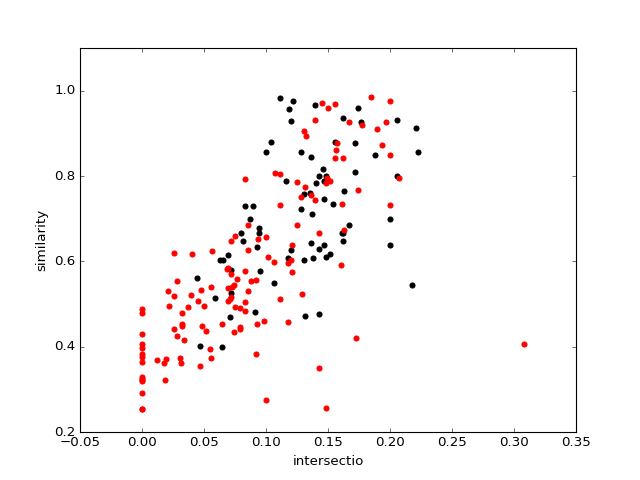

In [34]:
plt.figure()
plt.scatter(train[train.is_duplicate==1].intersection, train[train.is_duplicate==1].similarity, color='black')
plt.scatter(train[train.is_duplicate==0].intersection, train[train.is_duplicate==0].similarity, color='red')
plt.xlabel('intersectio')
plt.ylabel('similarity')
plt.show()

<IPython.core.display.Javascript object>


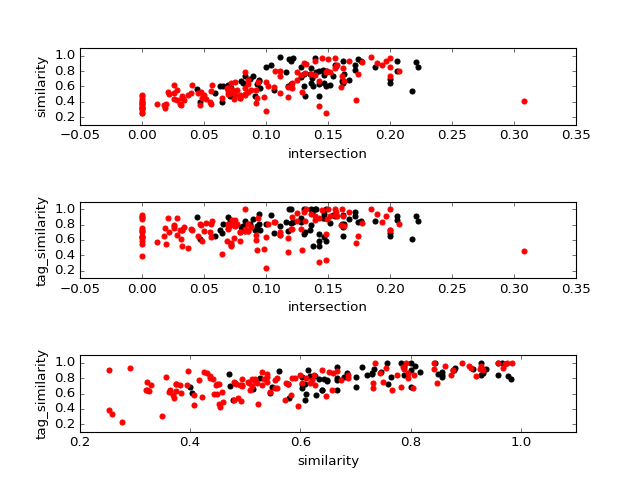

In [40]:
fig=plt.figure()
x1=fig.add_subplot(311)
x2=fig.add_subplot(312)
x3=fig.add_subplot(313)
x1.scatter(train[train.is_duplicate==1].intersection, train[train.is_duplicate==1].similarity, color='black')
x1.scatter(train[train.is_duplicate==0].intersection, train[train.is_duplicate==0].similarity, color='red')
x1.set_xlabel('intersection')
x1.set_ylabel('similarity')
x2.scatter(train[train.is_duplicate==1].intersection, train[train.is_duplicate==1].tag_similarity, color='black')
x2.scatter(train[train.is_duplicate==0].intersection, train[train.is_duplicate==0].tag_similarity, color='red')
x2.set_xlabel('intersection')
x2.set_ylabel('tag_similarity')
x3.scatter(train[train.is_duplicate==1].similarity, train[train.is_duplicate==1].tag_similarity, color='black')
x3.scatter(train[train.is_duplicate==0].similarity, train[train.is_duplicate==0].tag_similarity, color='red')
x3.set_xlabel('similarity')
x3.set_ylabel('tag_similarity')
plt.subplots_adjust(hspace=1)

## Creating a multi-layer neuronal network

In [27]:
from sklearn.neural_network import MLPClassifier

In [28]:
X = [[0., 0.], [1., 1.]]
y = [0, 1]

In [19]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [29]:
clf.predict([1,0])

/home/lenovo/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([0])

In [34]:
clf.predict_proba([1,0])

/home/lenovo/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[  1.00000000e+00,   1.56634271e-26]])